# Inference implementation tests

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import re
import subprocess
import datetime
from planar_ising import PlanarIsingModelGenerator, IsingInferenceAndSampling

np.random.seed(42)

# Problem statement

Let $V = \{ 1, ..., N \}, E \subseteq \binom{V}{2}, G = (V, E)$ be an undirected planar graph. For each $v \in V$ we assign a random binary variable (a spin) $s_v \in \{ -1, +1 \}$, $S = (s_1, ..., s_N)$. For each $e \in E$ we define a number $J_e \in \mathbb{R}$. We define a probability of the assignment $X = (x_1, ..., x_N) \in \{ -1, +1 \}^N$ as follows:

\begin{equation}
\mathbb{P} (S = X) = \frac{1}{Z} \exp{ \sum_{e = \{i, j\} \in E} J_e x_i x_j }
\label{eq:distr}
\end{equation}

Where

\begin{equation}
Z = \sum_{X \in \{ -1, +1 \}^N} \exp{ \sum_{e = \{i, j\} \in E} J_e x_i x_j }
\end{equation}

Given $G$'s plane embedding and a set of $J_e$, a goal is to find $Z$ efficiently.

In all the experiments conducted further we work with the following model generating parameters (check `PlanarIsingModelGenerator` docstrings):

In [2]:
graph_density = 0.8
interaction_values_std = 0.1

# Correctness of implementation

To prove correctness of partition function, we test the computed value against Kac-Ward approach [1, Theorem 1]. It is relatively simple to implement, and this is what the next cell does. The disadvantage of the approach is that it results in $O(| V |^3)$ time complexity, while our algorithm is $O(| V |^{\frac32})$.

Kac-Ward approach requires a straight line embedding of $G$. To find that, we use `straightline` executable borrowed from [here](https://github.com/jeffythedragonslayer/lipton-tarjan).

In [3]:
def compute_log_partition_function_kac_ward(ising_model):

    embedding_points = get_embedding_points(ising_model.graph)
    interactions_matrix = get_interactions_matrix(ising_model)

    spins_count = ising_model.graph.size

    kac_ward_matrix = get_kac_ward_matrix(embedding_points, interactions_matrix)

    _, kac_ward_det_log = np.linalg.slogdet(kac_ward_matrix)

    pairwise_interaction_coshs = np.cosh(interactions_matrix[np.triu_indices(spins_count)])

    return np.log(2)*spins_count + kac_ward_det_log/2 + \
            np.log(pairwise_interaction_coshs).sum()

def get_embedding_points(graph):

    edge_list_filename = 'edgelist.tmp'
    embedding_filename = 'embedding.tmp'
    embedding_command = './straightline {}'.format(edge_list_filename)

    edge_list_lines = []

    for vertex in range(graph.size):
        for adjacent_vertex in graph.get_adjacent_vertices(vertex):
            if vertex < adjacent_vertex:
                edge_list_lines.append('{0}, {1}'.format(vertex, adjacent_vertex))

    with open(edge_list_filename, 'w') as edge_list_file:
        edge_list_file.write('\n'.join(edge_list_lines))

    with open(embedding_filename, 'w') as embedding_file:
        subprocess.run(embedding_command.split(), stdout=embedding_file)

    pattern = re.compile(r'^\d+\[pos\=\"(\d+)\,(\d+)\!\"\]\;')

    embedding_points = []

    with open(embedding_filename, 'r') as embedding_file:
        for line in embedding_file:

            match = pattern.match(line)

            if match is None:
                continue

            embedding_points.append([float(match[1]), float(match[2])])

            if len(embedding_points) == graph.size:
                break

    return np.asarray(embedding_points)

def get_interactions_matrix(ising_model):

    graph = ising_model.graph
    interaction_values = ising_model.interaction_values

    interactions_matrix = np.zeros((graph.size, graph.size), dtype=np.float64)

    interactions_matrix[graph.edges.vertex1, graph.edges.vertex2] = interaction_values
    interactions_matrix[graph.edges.vertex2, graph.edges.vertex1] = interaction_values

    return interactions_matrix

def get_kac_ward_matrix(embedding_points, interactions_matrix):

    spins_count = len(embedding_points)

    directed_edge_indices = {edge:i for i, edge in \
            enumerate(zip(*np.where(interactions_matrix != 0)))}
    directed_edges_count = len(directed_edge_indices)

    kac_ward_matrix = np.zeros((directed_edges_count, directed_edges_count),
                               dtype=np.complex128)

    for spin_index1 in range(spins_count):

        for spin_index2 in range(spins_count):

            if interactions_matrix[spin_index1, spin_index2] == 0:
                continue

            directed_edge_index1 = directed_edge_indices[(spin_index1, spin_index2)]

            kac_ward_matrix[directed_edge_index1, directed_edge_index1] = 1

            for spin_index3 in range(spins_count):

                if interactions_matrix[spin_index2, spin_index3] == 0:
                    continue

                if spin_index1 == spin_index3:
                    continue

                point1 = embedding_points[spin_index1]
                point2 = embedding_points[spin_index2]
                point3 = embedding_points[spin_index3]

                half_rotation_number = get_half_rotation_complex_number(point1, point2,
                        point3)

                directed_edge_index2 = directed_edge_indices[(spin_index2, spin_index3)]

                kac_ward_matrix[directed_edge_index1, directed_edge_index2] = \
                        -half_rotation_number*\
                        np.tanh(interactions_matrix[spin_index2, spin_index3])

    return kac_ward_matrix

def get_half_rotation_complex_number(point1, point2, point3):

    vector1 = point2 - point1
    vector2 = point3 - point2

    dot_product = (vector1*vector2).sum()
    cross_product_z = vector1[0]*vector2[1] - vector1[1]*vector2[0]

    angle_cos = dot_product/(np.linalg.norm(vector1)*np.linalg.norm(vector2))
    half_angle_cos = np.sqrt((1 + angle_cos)/2)
    half_angle_sin = -np.sign(cross_product_z)*np.sqrt((1 - angle_cos)/2)

    return half_angle_cos + 1j*half_angle_sin

For a given model let $Z$ be a partition function computed by our algorithm and $Z'$ - by Kac-Ward approach. Then we define a relative error of our approach as $\frac{| \log Z - \log Z' |}{| \log Z' |}$.

The next cell generates Planar Ising Models of different size and computes relative error for them. Then errors are drawn as a scatter plot depending on the model size. One can observe that the error values are small enough to consider partition function values as correct.

Runtime warnings in the output are related to determinant computations in Kac-Ward approach, which suffers from numerical instabilities.

/home/valera/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in sqrt
/home/valera/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1741: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/home/valera/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/valera/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10


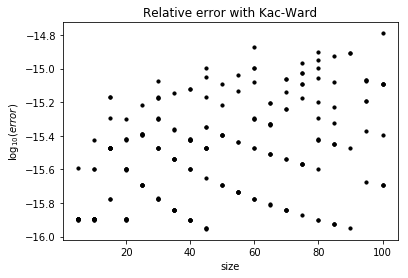

In [4]:
graph_sizes = np.arange(5, 105, 5)
samples_count = 20

graph_sizes_per_sample = []
relative_errors_per_sample = []

for graph_size in graph_sizes:

    for sample_index in range(samples_count):

        graph_sizes_per_sample.append(graph_size)

        ising_model = PlanarIsingModelGenerator.generate_random_model(graph_size,
                graph_density, interaction_values_std)

        kac_ward_log_partition_function = \
                compute_log_partition_function_kac_ward(ising_model)

        ising_inference = IsingInferenceAndSampling(ising_model)
        log_partition_function = ising_inference.compute_log_partition_function()

        relative_error = np.absolute((kac_ward_log_partition_function - \
                float(log_partition_function))/kac_ward_log_partition_function)

        relative_errors_per_sample.append(relative_error)

plt.scatter(graph_sizes_per_sample, np.log10(relative_errors_per_sample), s=10, c='k')
plt.title('Relative error with Kac-Ward')
plt.ylabel('$\log_{10} (error)$')
plt.xlabel('size')

plt.show()

# Execution time

The following cell generates Planar Ising Models of different size and measures the time of partition function computation. Then benchmarks are drawn on the scatter plot with model's size on x axis. Logarithmic axes clearly illustrate $O(| V |^{\frac32})$ time complexity of the algorithm.

Done with size 4
Done with size 8
Done with size 16
Done with size 32
Done with size 64
Done with size 128
Done with size 256
Done with size 512
Done with size 1024
Done with size 2048
Done with size 4096


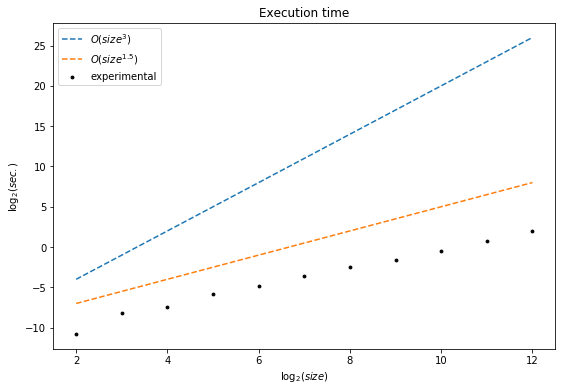

In [5]:
log2_graph_sizes = np.arange(2, 13)
samples_count = 1

log2_graph_sizes_per_sample = []
execution_times_per_samples = []

for log2_graph_size in log2_graph_sizes:

    graph_size = 2**log2_graph_size

    for sample_index in range(samples_count):

        log2_graph_sizes_per_sample.append(log2_graph_size)

        ising_model = PlanarIsingModelGenerator.generate_random_model(graph_size,
                graph_density, interaction_values_std)

        start_moment = datetime.datetime.now()

        ising_inference = IsingInferenceAndSampling(ising_model)
        ising_inference.compute_log_partition_function()

        execution_time = (datetime.datetime.now() - start_moment).total_seconds()

        execution_times_per_samples.append(execution_time)

    print('Done with size {}'.format(graph_size))

plt.figure(figsize=(9, 6))

plt.scatter(log2_graph_sizes_per_sample, np.log2(execution_times_per_samples),
        c='k', s=8, label='experimental')

plt.plot(log2_graph_sizes, 3*log2_graph_sizes - 10, '--', label='$O(size^3)$')
plt.plot(log2_graph_sizes, 1.5*log2_graph_sizes - 10, '--', label='$O(size^{1.5})$')

plt.title('Execution time')
plt.xlabel('$\log_2 (size)$')
plt.ylabel('$\log_2 (sec.)$')
plt.legend()

plt.show()

# References

[1] - J. K. Johnson, D. Oyen, M. Chertkov, and P. Netrapalli, "Learning planar ising models", J. Mach. Learn. Res., vol. 17, pp. 7539–7564, Jan. 2016.